#Python Code

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhruvildave/new-york-city-taxi-trips-2019")

print("Path to dataset files:", path)

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.38G/2.38G [01:11<00:00, 35.7MB/s]

Extracting files...


Path to dataset files: C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4


In [ ]:
import os
# List all files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['2019', 'data_dictionary.pdf', 'taxi_zones', 'taxi_zone_lookup.csv']


In [ ]:
# Define the dataset path
dataset_path = path

# List files inside '2019' directory
year_2019_path = os.path.join(dataset_path, "2019")
if os.path.exists(year_2019_path):
    print("Files in 2019 folder:", os.listdir(year_2019_path))

# List files inside 'taxi_zones' directory
taxi_zones_path = os.path.join(dataset_path, "taxi_zones")
if os.path.exists(taxi_zones_path):
    print("Files in taxi_zones folder:", os.listdir(taxi_zones_path))

Files in 2019 folder: ['2019-01.sqlite', '2019-02.sqlite', '2019-03.sqlite', '2019-04.sqlite', '2019-05.sqlite', '2019-06.sqlite', '2019-07.sqlite', '2019-08.sqlite', '2019-09.sqlite', '2019-10.sqlite', '2019-11.sqlite', '2019-12.sqlite']
Files in taxi_zones folder: ['taxi_zones.dbf', 'taxi_zones.prj', 'taxi_zones.sbn', 'taxi_zones.sbx', 'taxi_zones.shp', 'taxi_zones.shp.xml', 'taxi_zones.shx']


In [ ]:
import sqlite3
import pandas as pd
import os

# Define output CSV file
output_csv = "nyc_taxi_2019_combined.csv"

# Get all SQLite files
sqlite_files = [os.path.join(path, "2019", f) for f in os.listdir(os.path.join(path, "2019")) if f.endswith(".sqlite")]

# Create an empty CSV file with headers from the first file
first_file = sqlite_files[0]
conn = sqlite3.connect(first_file)
df_temp = pd.read_sql("SELECT * FROM tripdata LIMIT 1000;", conn)  # Load small preview
conn.close()
df_temp.to_csv(output_csv, index=False)  # Save headers only

# Append data month by month
for file in sqlite_files:
    print(f"Processing {file}...")
    conn = sqlite3.connect(file)

    # Read in chunks to prevent memory overload
    chunk_size = 500000  # Adjust based on system memory
    for chunk in pd.read_sql("SELECT * FROM tripdata;", conn, chunksize=chunk_size):
        chunk.to_csv(output_csv, mode='a', header=False, index=False)

    conn.close()
    print(f"Finished {file}")

print("All data saved to CSV without crashing!")

Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-01.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-01.sqlite
Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-02.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-02.sqlite
Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-03.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-03.sqlite
Processing C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-04.sqlite...
Finished C:\Users\crist\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4\2019\2019-04.sql

In [ ]:
import pandas as pd

# Load only first 10,000 rows
df = pd.read_csv("nyc_taxi_2019_combined.csv", nrows=10000, low_memory=False)

# Convert datetime columns
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Remove invalid trip distances & fares
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0)]

print(df.info())
print(df.head())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 9923 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   vendorid               9923 non-null   float64       
 1   tpep_pickup_datetime   9923 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  9923 non-null   datetime64[ns]
 3   passenger_count        9923 non-null   float64       
 4   trip_distance          9923 non-null   float64       
 5   ratecodeid             9923 non-null   float64       
 6   store_and_fwd_flag     9923 non-null   object        
 7   pulocationid           9923 non-null   float64       
 8   dolocationid           9923 non-null   float64       
 9   payment_type           9923 non-null   float64       
 10  fare_amount            9923 non-null   float64       
 11  extra                  9923 non-null   float64       
 12  mta_tax                9923 non-null   float64       
 13  tip_amou

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize numeric columns
scaler = StandardScaler()
df[['trip_distance', 'fare_amount', 'total_amount', 'tolls_amount']] = scaler.fit_transform(df[['trip_distance', 'fare_amount', 'total_amount', 'tolls_amount']])

# Convert categorical fields to numerical encoding
df['payment_type'] = df['payment_type'].astype(int)
df['vendorid'] = df['vendorid'].astype(int)
df['ratecodeid'] = df['ratecodeid'].astype(int)

# Remove outliers using IQR
Q1 = df[['fare_amount', 'trip_distance']].quantile(0.25)
Q3 = df[['fare_amount', 'trip_distance']].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[['fare_amount', 'trip_distance']] < (Q1 - 1.5 * IQR)) | (df[['fare_amount', 'trip_distance']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Data Cleaning Complete!")

Data Cleaning Complete!


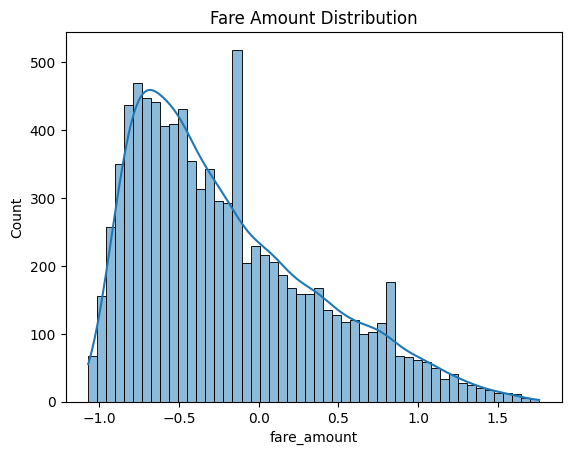

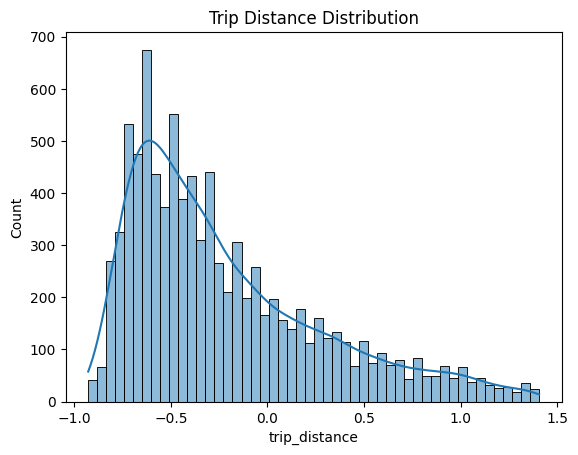

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Histogram of fares
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title("Fare Amount Distribution")
plt.show()

# Histogram of trip distances
sns.histplot(df['trip_distance'], bins=50, kde=True)
plt.title("Trip Distance Distribution")
plt.show()

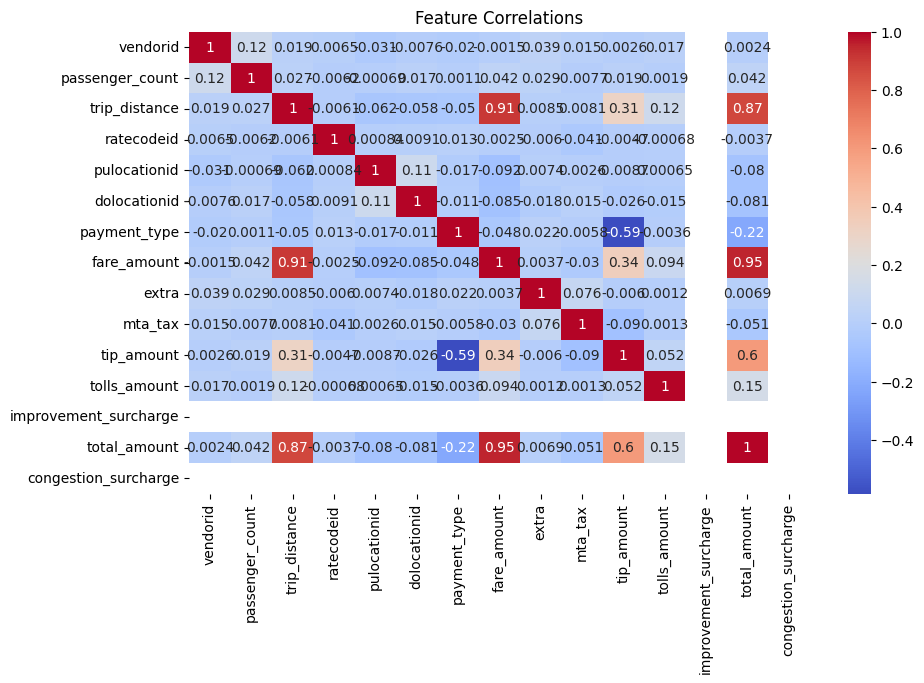

In [ ]:
# Select only numeric columns for correlation matrix
df_numeric = df.select_dtypes(include=[np.number])

# Compute correlation
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


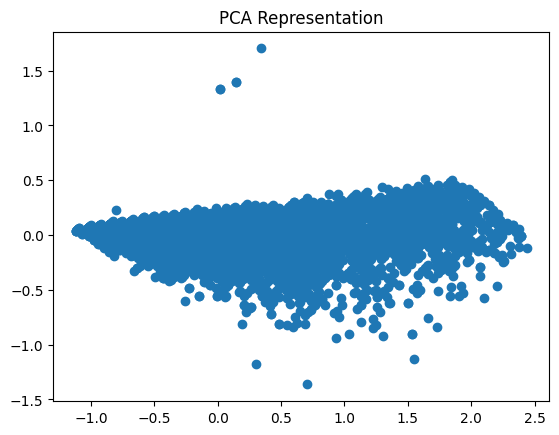

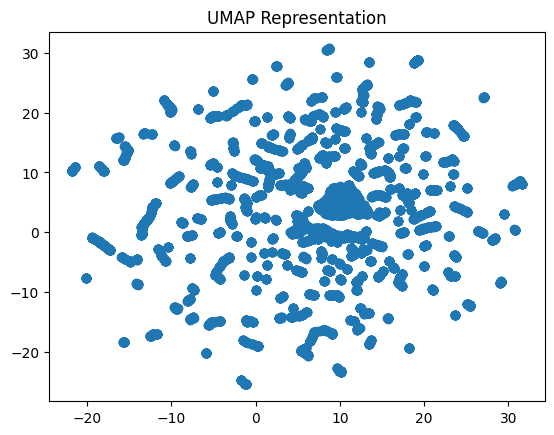

In [13]:
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Apply PCA (Linear)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df[['trip_distance', 'fare_amount']])
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA Representation")
plt.show()

# Apply UMAP (Non-Linear)
X_umap = umap.UMAP(n_components=2).fit_transform(df[['trip_distance', 'fare_amount']])
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title("UMAP Representation")
plt.show()

In [14]:
# Extract time-based features
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

# Trip duration (minutes)
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Speed (miles per hour)
df['speed_mph'] = df['trip_distance'] / (df['trip_duration'] / 60 + 1e-6)

# Weekend indicator
df['is_weekend'] = (df['pickup_weekday'] >= 5).astype(int)

# Rush hour indicator (Morning: 7-9 AM, Evening: 5-7 PM)
df['is_rush_hour'] = df['pickup_hour'].apply(lambda x: 1 if x in [7, 8, 17, 18] else 0)

# Nighttime trip indicator (Midnight - 5 AM)
df['is_night'] = (df['pickup_hour'] < 6).astype(int)

# High-fare trip classification
df['high_fare'] = (df['fare_amount'] > df['fare_amount'].median()).astype(int)

# Save cleaned and feature-engineered dataset
df.to_csv("nyc_taxi_final.csv", index=False)
print("Feature Engineering Complete!")

Feature Engineering Complete!


In [16]:
from scipy.stats import f_oneway

# Perform ANOVA test
anova_result = f_oneway(
    df[df['payment_type'] == 1]['fare_amount'],  # Credit card
    df[df['payment_type'] == 2]['fare_amount'],  # Cash
    df[df['payment_type'] == 3]['fare_amount']   # No charge 
)

print("ANOVA Test Result:", anova_result)

ANOVA Test Result: F_onewayResult(statistic=13.48663040723892, pvalue=1.417178567146563e-06)


Part2

In [2]:
import pandas as pd

# Load the final processed dataset
df = pd.read_csv("nyc_taxi_final.csv")

# Check the first few rows
print(df.head())

   vendorid tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2019-01-01 00:46:40   2019-01-01 00:53:20              1.0   
1         1  2019-01-01 00:59:47   2019-01-01 01:18:59              1.0   
2         1  2019-01-01 00:21:28   2019-01-01 00:28:37              1.0   
3         1  2019-01-01 00:32:01   2019-01-01 00:45:39              1.0   
4         1  2019-01-01 00:57:32   2019-01-01 01:09:32              2.0   

   trip_distance  ratecodeid store_and_fwd_flag  pulocationid  dolocationid  \
0      -0.441643           1                  N         151.0         239.0   
1      -0.082501           1                  N         239.0         246.0   
2      -0.506941           1                  N         163.0         229.0   
3       0.276640           1                  N         229.0           7.0   
4      -0.245747           1                  N         141.0         234.0   

   payment_type  ...  pickup_hour  pickup_day  pickup_weekday  pickup_mont

In [3]:
df.dtypes

vendorid                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
ratecodeid                 int64
store_and_fwd_flag        object
pulocationid             float64
dolocationid             float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
pickup_hour                int64
pickup_day                 int64
pickup_weekday             int64
pickup_month               int64
trip_duration            float64
speed_mph                float64
is_weekend                 int64
is_rush_hour               int64
is_night                   int64
high_fare                  int64
dtype: object

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# kNN algorithm implementation from scratch
class KNN:
    def __init__(self, k=3):
        self.k = k

    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2)**2))

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = [self.euclidean_distance(test_point, train_point) for train_point in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            most_common = np.bincount(k_nearest_labels).argmax()
            predictions.append(most_common)
        return np.array(predictions)

# Prepare the data with features
X = df[['trip_distance', 'fare_amount', 'total_amount', 'tolls_amount',
        'pickup_hour', 'pickup_day', 'pickup_weekday', 'pickup_month',
        'trip_duration', 'speed_mph', 'is_weekend', 'is_rush_hour', 'is_night','pulocationid','passenger_count','payment_type','improvement_surcharge','tip_amount','mta_tax','extra']].values
y = df['high_fare'].values  # Target: high_fare (classification)


# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# kNN Model
knn = KNN(k=3)
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate performance
print("kNN Accuracy:", accuracy_score(y_test, y_pred_knn))



kNN Accuracy: 0.9662676822633297


In [5]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9978237214363439
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       852

    accuracy                           1.00      1838
   macro avg       1.00      1.00      1.00      1838
weighted avg       1.00      1.00      1.00      1838



c:\Users\crist\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=4, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluate performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       852

    accuracy                           1.00      1838
   macro avg       1.00      1.00      1.00      1838
weighted avg       1.00      1.00      1.00      1838



In [7]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Evaluate performance
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       852

    accuracy                           1.00      1838
   macro avg       1.00      1.00      1.00      1838
weighted avg       1.00      1.00      1.00      1838



In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Neural Network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (high_fare: 1 or 0)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Deep Learning Model Accuracy: {test_acc}")

Epoch 1/10
230/230 [==============================] - 2s 3ms/step - loss: 0.3454 - accuracy: 0.9049
Epoch 2/10
230/230 [==============================] - 1s 2ms/step - loss: 0.2138 - accuracy: 0.9513
Epoch 3/10
230/230 [==============================] - 1s 2ms/step - loss: 0.1511 - accuracy: 0.9612
Epoch 4/10
230/230 [==============================] - 1s 2ms/step - loss: 0.1291 - accuracy: 0.9631
Epoch 5/10
230/230 [==============================] - 1s 2ms/step - loss: 0.1076 - accuracy: 0.9695
Epoch 6/10
230/230 [==============================] - 1s 2ms/step - loss: 0.1270 - accuracy: 0.9654
Epoch 7/10
230/230 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.9752
Epoch 8/10
230/230 [==============================] - 1s 2ms/step - loss: 0.0940 - accuracy: 0.9751
Epoch 9/10
230/230 [==============================] - 1s 2ms/step - loss: 0.1181 - accuracy: 0.9701
Epoch 10/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.9728
D

Silhouette Score: 0.9403513713061741


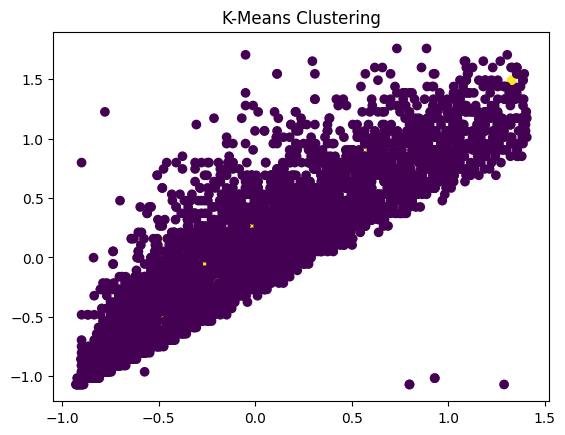

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

# K-Means Clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X)

# Cluster assignments
labels = kmeans.labels_

# Compute Silhouette Score
silhouette = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette}")

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("K-Means Clustering")
plt.show()